In [1]:
%matplotlib widget

import os
import sys
import brainweb
import torch
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
import nibabel as nib
import sirf.STIR as stir
msg_red = stir.MessageRedirector('info.txt', 'warnings.txt')
import matplotlib.pyplot as plt
import os
import sirf.Reg as reg
from math import cos, sin, pi, radians
from sirf.Utilities import examples_data_path
#from sirf_exercises import exercises_data_path
import shutil
#from scipy.ndimage.filters import gaussian_filter
from tqdm.auto import tqdm
# add the source directory to the path
# This is to make everything nice and self-contained
dir_path = os.path.dirname(os.getcwd())
source_path = os.path.join(dir_path, 'source')
sys.path.append(source_path)
from data.ellipses import EllipsesDataset
from reconstruction.reconstruction import *
from reconstruction.registration import *
from reconstruction.osem import *
from plotting_functions import plot_2d_image
import matplotlib.pyplot as plt
import imageio
from plotting_functions import *
from IPython.display import Image
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

msg_red = stir.MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')
# load model 
path_to_data = os.path.join(os.path.dirname(os.getcwd()), 'source', 'models')
sys.path.append(path_to_data)

from models import UNet, UNet_2, UNet_og

model = UNet_og.UNet(in_channels=3, n_class=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#model_path = '/home/sirfuser/shared/fine_tuned/difference/median/model_m_UNet_n10000_e1000_lr1e-05_b32_s0.8_0.1_r0_gFalse/final_model+202509020730.pth'
#model_path = '/home/sirfuser/shared/fine_tuned/difference/mean/model_m_UNet_n10000_e1000_lr1e-05_b32_s0.8_0.1_r0_gFalse/final_model+202509012209.pth'
#model_path = '/home/sirfuser/shared/fine_tuned/difference/max/model_m_UNet_n10000_e1000_lr1e-05_b32_s0.8_0.1_r0_gFalse/final_model+202509011414.pth'
model_path = '/home/sirfuser/shared/fine_tuned/difference/median/ft/fine_tuned_model+202509162149.pth'



if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device) 
    model.load_state_dict(checkpoint['model_state_dict'])      
    print(f"Model loaded from {model_path}")
else:
    print(f"ERROR: Model file not found at {model_path}")



Model loaded from /home/sirfuser/shared/fine_tuned/difference/median/ft/fine_tuned_model+202509162149.pth


In [2]:
from torch.utils.data import Dataset

mu_water = 0.096

class BrainWebTestDataset(Dataset):
    def __init__(self, sens_images, attn_images, emis_images, transformed_attn_images, transformed_sens_images, template_sinogram): 
        self.sens_images = sens_images
        self.attn_images = attn_images
        self.emis_images = emis_images
        self.transformed_attn_images = transformed_attn_images
        self.transformed_sens_images = transformed_sens_images
        self.template_sinogram = template_sinogram

    def __len__(self):
        return len(self.sens_images)

    def __getitem__(self, idx):
        sens = self.sens_images[idx]
        attn = self.attn_images[idx]
        emis = self.emis_images[idx]
        transformed_attn = self.transformed_attn_images[idx]
        transformed_sens = self.transformed_sens_images[idx]
        
        # Get data as arrays
        sens_array = sens.as_array()
        attn_array = attn.as_array()
        trans_attn_array = transformed_attn.as_array()
        trans_sens_array = transformed_sens.as_array()

        # Create non-attenuated sensitivity images for normalisation
        acq_model_no_attn = stir.AcquisitionModelUsingRayTracingMatrix()
        acq_model_no_attn.set_num_tangential_LORs(10)
        acq_model_no_attn.set_up(self.template_sinogram, emis)
        uniform_acq_data = self.template_sinogram.get_uniform_copy(1.0)
        non_att = acq_model_no_attn.backward(uniform_acq_data)
        non_att_array = non_att.as_array()
        denom = np.median(non_att_array) + 1e-8  # normalise by median of non-attenuated sensitivity image
        #denom = float(non_att_array.max()) + 1e-8 # normalise by max of non-attenuated sensitivity image
        #denom = np.mean(non_att_array) + 1e-8 # normalise by mean of non_attenuated sensitivity image

        # Normalise data
        sens_norm = sens_array/denom
        attn_norm = attn_array/mu_water 
        trans_attn_norm = trans_attn_array/mu_water
        trans_sens_norm = trans_sens_array/denom
        attn_diff = trans_attn_norm - attn_norm
        sens_difference = trans_sens_norm - sens_norm

        x_sens = sens_norm.squeeze()
        x_attn_diff = attn_diff.squeeze()
        x_attn_trans = trans_attn_norm.squeeze()
        x = np.array([x_sens, x_attn_trans, x_attn_diff])  # inputs

        y = sens_difference
        if y.ndim == 2:
            y = y[None, ...]   

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(denom, dtype=torch.float32)


In [3]:
import torch
import numpy as np

dir_path = os.path.dirname(os.getcwd())
#output_dir = '/home/sirfuser/shared/ft_test/'
output_dir = '/home/sirfuser/devel/PET_sensitivity/data/test_data'
template_path = os.path.join(dir_path, 'data', 'template_data')
template_sinogram = stir.AcquisitionData(os.path.join(template_path, 'template_sinogram.hs'))


sens_images = []
attn_images = []
emis_images = []
transformed_attn_images = []
transformed_sens_images = []

num_subjects = [2, 6, 11, 17]
num_slices = 5


for i in num_subjects:
    for j in range(1, num_slices + 1):
        sens = stir.ImageData(os.path.join(output_dir, f'sens_{i}_{j}.hv'))
        attn = stir.ImageData(os.path.join(output_dir, f'attn_{i}_{j}.hv'))
        emis = stir.ImageData(os.path.join(output_dir, f'emission_{i}_{j}.hv'))
        transformed_attn = stir.ImageData(os.path.join(output_dir, f'transform_attn_{i}_{j}.hv'))
        transformed_sens = stir.ImageData(os.path.join(output_dir, f'transform_sens_{i}_{j}.hv'))
        sens_images.append(sens)
        attn_images.append(attn)
        emis_images.append(emis)
        transformed_attn_images.append(transformed_attn)
        transformed_sens_images.append(transformed_sens)

test_dataset = BrainWebTestDataset(sens_images, attn_images, emis_images, transformed_attn_images, transformed_sens_images, template_sinogram)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
# Save model output for reconstruction

import sirf.STIR as stir
import numpy as np
import os
import torch

save_dir = os.path.join(dir_path, "data", "new_ft_diff")
os.makedirs(save_dir, exist_ok=True)

num_slices = 5
test_subjects = [2, 6, 11, 17]

model.eval()
with torch.no_grad():
    for idx, (X, y, denom) in enumerate(test_loader):
        X, y, denom = X.to(device), y.to(device), denom.to(device)
        out = model(X).squeeze(1)  # difference output [B,H,W]

        orig_sens_norm = X[:, 0, :, :]        # [B,H,W]
        pred_trans_norm = orig_sens_norm + out
        # (you could also compute true_trans_norm = orig_sens_norm + y.squeeze(1))

        # denormalise full predicted transformed sensitivity
        pred_trans = pred_trans_norm * denom.view(-1, 1, 1)  # [B,H,W]

        for b in range(pred_trans.size(0)):
            global_idx = idx * test_loader.batch_size + b

            subject = test_subjects[global_idx // num_slices]
            slice_num = (global_idx % num_slices) + 1

            # prepare array for SIRF [1,H,W]
            pred_np = pred_trans[b].detach().cpu().numpy()
            pred_np = pred_np[np.newaxis, :, :]

            template = test_loader.dataset.sens_images[global_idx]
            pred_image = template.clone()
            pred_image.fill(pred_np)

            filename = f"pred_sens_{subject}_{slice_num}.hv"
            filepath = os.path.join(save_dir, filename)
            pred_image.write(filepath)

            try:
                template_name = os.path.basename(template.filename())
            except AttributeError:
                template_name = "<no filename available>"

            print(f"global_idx={global_idx:2d} | expected: sens_{subject}_{slice_num}.hv "
                  f"| template: {template_name} | saved: {filename}")


global_idx= 0 | expected: sens_2_1.hv | template: <no filename available> | saved: pred_sens_2_1.hv
global_idx= 1 | expected: sens_2_2.hv | template: <no filename available> | saved: pred_sens_2_2.hv
global_idx= 2 | expected: sens_2_3.hv | template: <no filename available> | saved: pred_sens_2_3.hv
global_idx= 3 | expected: sens_2_4.hv | template: <no filename available> | saved: pred_sens_2_4.hv
global_idx= 4 | expected: sens_2_5.hv | template: <no filename available> | saved: pred_sens_2_5.hv
global_idx= 5 | expected: sens_6_1.hv | template: <no filename available> | saved: pred_sens_6_1.hv
global_idx= 6 | expected: sens_6_2.hv | template: <no filename available> | saved: pred_sens_6_2.hv
global_idx= 7 | expected: sens_6_3.hv | template: <no filename available> | saved: pred_sens_6_3.hv
global_idx= 8 | expected: sens_6_4.hv | template: <no filename available> | saved: pred_sens_6_4.hv
global_idx= 9 | expected: sens_6_5.hv | template: <no filename available> | saved: pred_sens_6_5.hv


Global Test Set RMSE: 0.288341


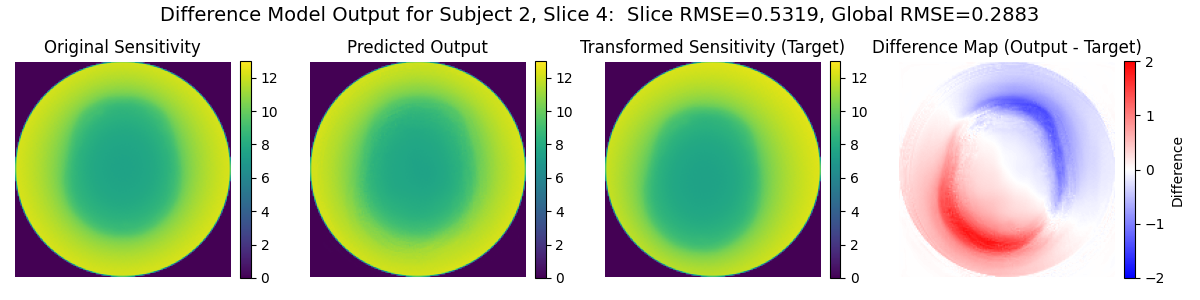

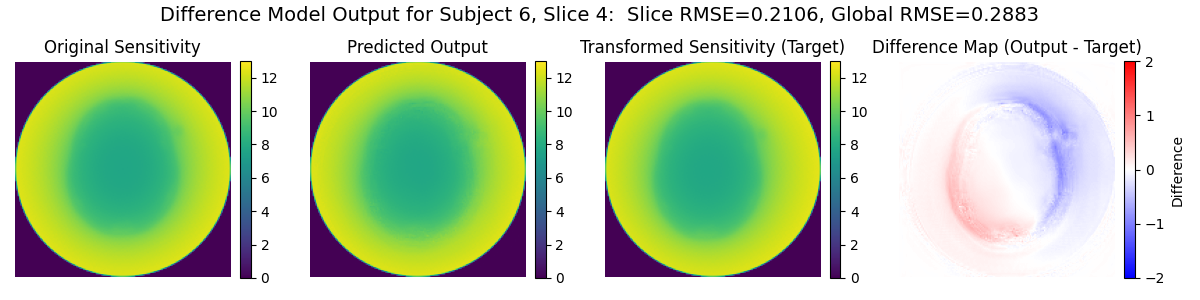

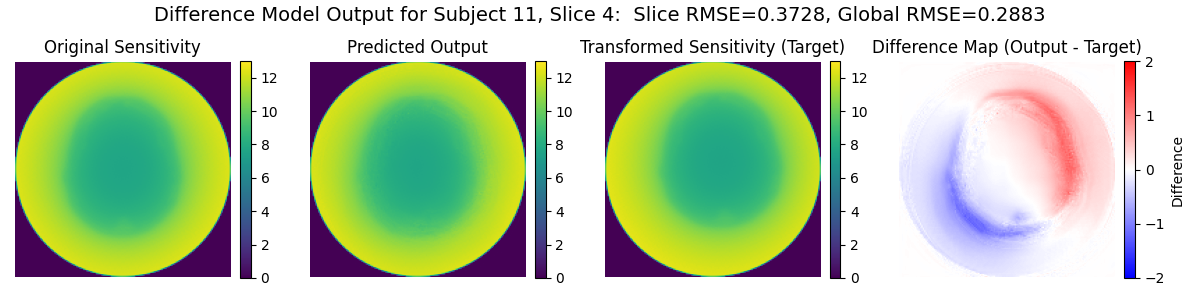

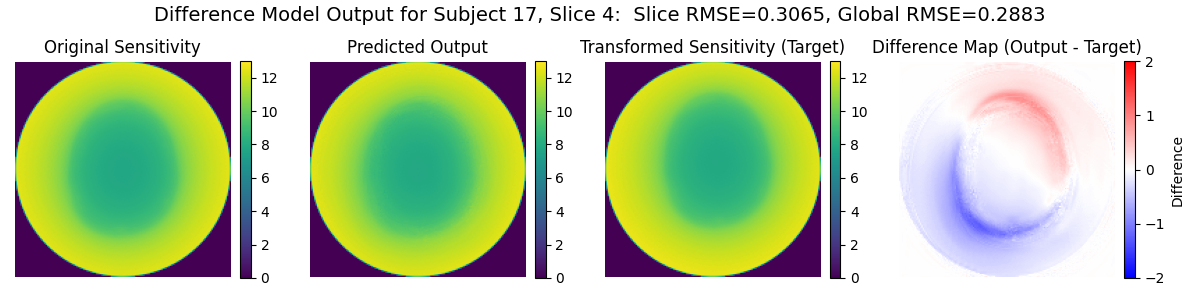

In [8]:
# Test model and save or show model output plots

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compute_rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2)).item()


total_rmse = 0.0
count = 0

model.eval()
with torch.no_grad():
    for X, y, denom in test_loader:
        X, y, denom = X.to(device), y.to(device), denom.to(device)
        out = model(X).squeeze(1)

        orig_sens_norm = X[:, 0, :, :]
        pred_trans_norm = orig_sens_norm + out
        true_trans_norm = orig_sens_norm + y.squeeze(1)

        pred_trans = pred_trans_norm * denom.view(-1, 1, 1)
        true_trans = true_trans_norm * denom.view(-1, 1, 1)

        # per-image RMSE in this batch
        batch_rmse = torch.sqrt(
            F.mse_loss(pred_trans, true_trans, reduction="none")
            .view(pred_trans.size(0), -1)
            .mean(dim=1)
        )
        total_rmse += batch_rmse.sum().item()
        count += batch_rmse.numel()

global_rmse = total_rmse / count
print(f"Global Test Set RMSE: {global_rmse:.6f}")

# shows slice for each subject 
slices_per_subject = 5  
slice_choice = 3  # either "first", "middle", "last", or int

with torch.no_grad():
    for subj_idx, subj_number in enumerate(num_subjects):
        if slice_choice == "first":
            dataset_idx = subj_idx * slices_per_subject
        elif slice_choice == "middle":
            dataset_idx = subj_idx * slices_per_subject + slices_per_subject // 2
        elif slice_choice == "last":
            dataset_idx = subj_idx * slices_per_subject + (slices_per_subject - 1)
        else:
            dataset_idx = subj_idx * slices_per_subject + int(slice_choice)

        slice_num = (dataset_idx % slices_per_subject) + 1

        X, y, denom = test_dataset[dataset_idx]
        X = X.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)
        denom = denom.unsqueeze(0).to(device)

        out = model(X).squeeze(1)
        orig_sens_norm = X[:, 0, :, :]
        pred_trans_norm = orig_sens_norm + out
        true_trans_norm = orig_sens_norm + y.squeeze(1)

        pred_trans = pred_trans_norm * denom.view(-1, 1, 1)
        true_trans = true_trans_norm * denom.view(-1, 1, 1)
        orig_sens  = orig_sens_norm * denom.view(-1, 1, 1)

        pred_np = pred_trans[0].detach().cpu().numpy()
        true_np = true_trans[0].detach().cpu().numpy()
        orig_np = orig_sens[0].detach().cpu().numpy()
        diff_map = pred_np - true_np

        # RMSE for each slice
        slice_rmse = compute_rmse(pred_trans, true_trans)

        diff_abs_max = max(abs(diff_map.min()), abs(diff_map.max()))
        vmin = 0
        vmax= 13

        # plots
        plt.figure(figsize=(12, 3))

        plt.subplot(1, 4, 1)
        im1 = plt.imshow(orig_np, cmap="viridis", vmin=vmin, vmax=vmax)
        plt.title("Original Sensitivity")
        plt.axis("off"); plt.colorbar(im1, fraction=0.046, pad=0.04)

        plt.subplot(1, 4, 2)
        im2 = plt.imshow(pred_np, cmap="viridis", vmin=vmin, vmax=vmax)
        plt.title("Predicted Output")
        plt.axis("off"); plt.colorbar(im2, fraction=0.046, pad=0.04)

        plt.subplot(1, 4, 3)
        im3 = plt.imshow(true_np, cmap="viridis", vmin=vmin, vmax=vmax)
        plt.title("Transformed Sensitivity (Target)")
        plt.axis("off"); plt.colorbar(im3, fraction=0.046, pad=0.04)

        plt.subplot(1, 4, 4)
        im4 = plt.imshow(diff_map, cmap="bwr", vmin=-2, vmax=2)
        plt.title("Difference Map (Output - Target)")
        plt.axis("off"); plt.colorbar(im4, fraction=0.046, pad=0.04, label="Difference")

        # suptitle shows subject, slice, slice RMSE, and global RMSE
        plt.suptitle(
            f"Difference Model Output for Subject {subj_number}, Slice {slice_num}:  "
            f"Slice RMSE={slice_rmse:.4f}, Global RMSE={global_rmse:.4f}",
            fontsize=14, x=0.5
        )
        plt.tight_layout()
        plt.subplots_adjust(top=0.82, wspace=0.25)

        # save 
        # save_dir = '/home/sirfuser/devel/PET_sensitivity/data/results/'
        # save_path = os.path.join(save_dir, f"difference_model_Subject_{subj_number}_Slice_{slice_num}.png")
        # plt.savefig(save_path, dpi=300, bbox_inches="tight")
        # plt.close()

        plt.show()
